<a href="https://colab.research.google.com/github/iurykischka/Proc.-de-sinais/blob/master/Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
import requests

# Som do beat
response = requests.get('https://github.com/iurykischka/Proc.-de-sinais/blob/master/untitled.wav?raw=true')
open("untitled.wav", "wb").write(response.content)
fs, beat = wavfile.read('untitled.wav')
beat = beat[:,0] # sinal do beat

tempo = np.arange(len(beat))/fs # variável TEMPO (em segundos)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == '__main__':


In [86]:
ipd.Audio(beat, rate=fs, normalize=True)

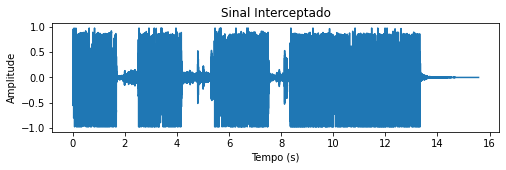

In [96]:
T = 1/fs
N=len(beat)
t1 = np.arange(0, N*T, T) #vetor de tempo (segundos)
# tempo = np.linspace(0, T, 1)
plt.figure(figsize=(8,2))
plt.plot(t1, beat);
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal Interceptado");

In [88]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft

def fourier(x, t, Hz=False, dB=False, deg=False, Nfft=None):

    N = len(x)

    if Nfft == None:
      Nfft = N

    X_f = fft(x, n=Nfft)
    X_f = X_f/N # corrige amplitude do sinal
    X_f = X_f[:Nfft//2]
    X_f[1:] = 2*X_f[1:]

    if Hz == True:
      f0 = 1/(Nfft*T) #freq em Hz
      fHz = np.arange(Nfft)*f0 #freq em Hz
      f = fHz[:Nfft//2]
    else:
      w0 = 2*np.pi/(Nfft*T) #freq em rad/s
      wRad = np.arange(Nfft)*w0 #freq em rad/s
      f = wRad[:Nfft//2]

    if dB == True:
      mag = 20*np.log10(np.abs(X_f)) #modulo no dominio da frequencia em dB
    else:
      mag = np.abs(X_f) #modulo no dominio da frequencia em dB
      
    if deg == True:
      pha = np.angle(X_f, deg=1) #fase no dominio da frequencia 
    else:
      pha = np.angle(X_f, deg=0)
           
    return mag, pha, f;

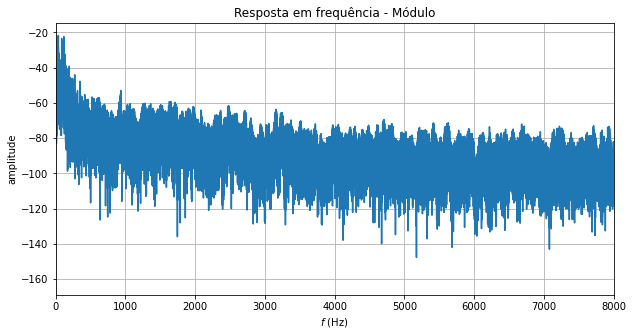

In [97]:
mag1, pha1, f1 = fourier(beat, t1, Hz=True, dB=True, deg=False, Nfft=None); #gera o grafico da entrada em frequencia

plt.figure(figsize=(10,5));
plt.plot(f1, mag1);
plt.title("Resposta em frequência - Módulo");
plt.ylabel("amplitude");
plt.xlabel("$f$ (Hz)");
plt.xlim(0,8000)
plt.grid(1);


In [90]:
#Especificações do Filtro

Gp = -1.32 #dB log(Sp^20) = Gp
Gr = -69 #dB
dp = 1-(10**(Gp/20))
dr = 10**(Gr/20)
Ap = -Gp #dB
Ar = -Gr #dB
fp1 = 62 #Hz
fp2 = 144 #Hz
fr1 = 37 #Hz
fr2 = 198 #Hz

wp1 = fp1*(2*np.pi) #rad/s
wp2 = fp2*(2*np.pi) #rad/s
wr1 = fr1*(2*np.pi) #rad/s
wr2 = fr2*(2*np.pi) #rad/s


print("FILTRO do tipo Passa-Faixa")
print(" - Ap: %.2f"%Ap)
print(" - Ar: %.2f"%Ar)
print(" - Gp: %.2f"%Gp)
print(" - Gr: %.2f"%Gr)
print(" - dp: %.2f"%dp)
print(" - dr: %.2f"%dr);

FILTRO do tipo Passa-Faixa
 - Ap: 1.32
 - Ar: 69.00
 - Gp: -1.32
 - Gr: -69.00
 - dp: 0.14
 - dr: 0.00


14 8 8 6


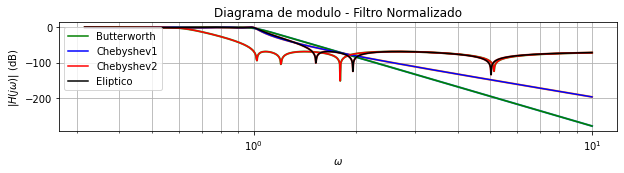

In [91]:
# Ordem dos filtros
ord1, wn1 = signal.buttord([wp1, wp2], [wr1, wr2], Ap, Ar, analog=True)
ord2, wn2 = signal.cheb1ord([wp1, wp2], [wr1, wr2], Ap, Ar, analog=True)
ord3, wn3 = signal.cheb2ord([wp1, wp2], [wr1, wr2], Ap, Ar, analog=True)
ord4, wn4 = signal.ellipord([wp1, wp2], [wr1, wr2], Ap, Ar, analog=True)

print(ord1, ord2, ord3, ord4)

# Filtros protótipos

z1, p1, k1 = signal.buttap(ord1)
z2, p2, k2 = signal.cheb1ap(ord2, Ap)
z3, p3, k3 = signal.cheb2ap(ord3, Ar)
z4, p4, k4 = signal.ellipap(ord4, Ap, Ar)

sys1ap = signal.lti(z1, p1, k1)
sys2ap = signal.lti(z2, p2, k2)
sys3ap = signal.lti(z3, p3, k3)
sys4ap = signal.lti(z4, p4, k4)

# Bode

w = np.logspace(-0.5, 1, 1000) # vetor de frequencias

w, mag1, phase1 = signal.bode(sys1ap, w)
w, mag2, phase2 = signal.bode(sys2ap, w)
w, mag3, phase3 = signal.bode(sys3ap, w)
w, mag4, phase4 = signal.bode(sys4ap, w)

# Gráfico (módulo)

plt.figure(figsize=(10,2))
plt.semilogx(w, mag1, lw=2) #Butter
plt.semilogx(w, mag2, lw=2) #Cheby 1
plt.semilogx(w, mag3, lw=2) #Cheby 2
plt.semilogx(w, mag4, lw=2) #Elíptico

plt.title("Diagrama de modulo - Filtro Normalizado")
plt.xlabel("$\omega$")
plt.ylabel("$|H(j\omega)|$ (dB)")
plt.grid(which="both")
plt.semilogx(w, mag1,color = "green",label = "Butterworth") 
plt.semilogx(w, mag2,color = "blue",label = "Chebyshev1") 
plt.semilogx(w, mag3,color = "red",label = "Chebyshev2") 
plt.semilogx(w, mag4,color = "black",label = "Eliptico") 
legend = plt.legend(loc='upper left')

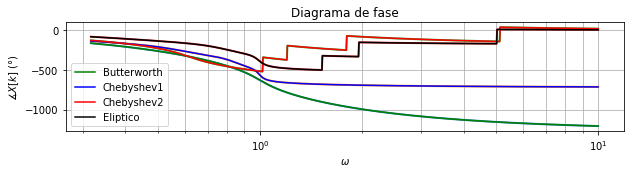

In [92]:
# Gráfico (fase)

plt.figure(figsize=(10,2))
plt.semilogx(w, phase1, lw=2) #Butter
plt.semilogx(w, phase2, lw=2) #Cheby 1
plt.semilogx(w, phase3, lw=2) #Cheby 2
plt.semilogx(w, phase4, lw=2) #Elíptico

plt.title("Diagrama de fase")
plt.xlabel("$\omega$")
plt.ylabel("$\measuredangle X[k]$ (°)")
plt.grid(which="both")
plt.semilogx(w, phase1,color = "green",label = "Butterworth") 
plt.semilogx(w, phase2,color = "blue",label = "Chebyshev1") 
plt.semilogx(w, phase3,color = "red",label = "Chebyshev2") 
plt.semilogx(w, phase4,color = "black",label = "Eliptico") 
legend = plt.legend(loc=3)

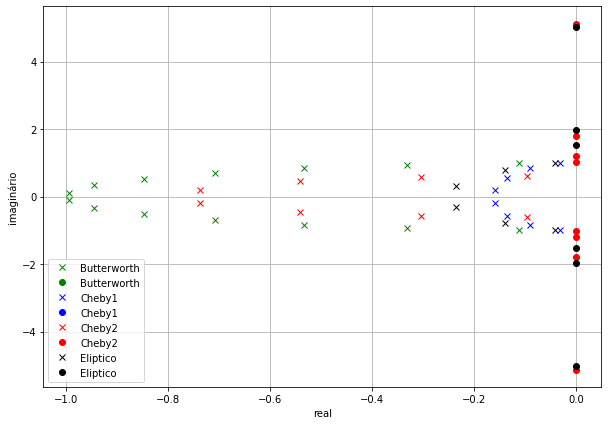

In [93]:
plt.figure(figsize=(10,7))

plt.plot(np.real(p1), np.imag(p1), "gx",label="Butterworth");
plt.plot(np.real(z1), np.imag(z1), "go",label="Butterworth"); 
plt.plot(np.real(p2), np.imag(p2), "bx",label="Cheby1");
plt.plot(np.real(z2), np.imag(z2), "bo",label="Cheby1");
plt.plot(np.real(p3), np.imag(p3), "rx",label="Cheby2");
plt.plot(np.real(z3), np.imag(z3), "ro",label="Cheby2");
plt.plot(np.real(p4), np.imag(p4), "kx",label="Eliptico");
plt.plot(np.real(z4), np.imag(z4), "ko",label="Eliptico");

legend = plt.legend(loc=3)
plt.xlabel("real")
plt.ylabel("imaginário")
#plt.axis([-2,2,-2,2]);
plt.grid(which="both");

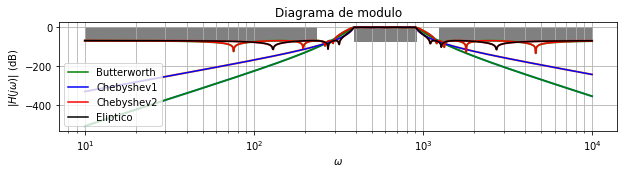

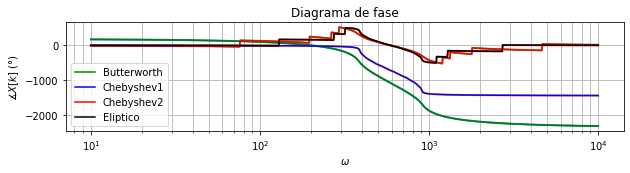

In [94]:
# Filtros

z1, p1, k1 = signal.butter(ord1, wn1, btype='bp', analog=True, output='zpk') #filtro butterworth
z2, p2, k2 = signal.cheby1(ord2, Ap, wn2, btype='bp', analog=True, output='zpk') #filtro chebychev 1
z3, p3, k3 = signal.cheby2(ord3, Ar, wn3, btype='bp', analog=True, output='zpk') #filtro chebychev 2
z4, p4, k4 = signal.ellip(ord4, Ap, Ar, wn4, btype='bp', analog=True, output='zpk') #filtro eliptico

sys1 = signal.lti(z1, p1, k1) 
sys2 = signal.lti(z2, p2, k2)
sys3 = signal.lti(z3, p3, k3)
sys4 = signal.lti(z4, p4, k4)


# Bode

w = np.logspace(1, 4, 1000) #cria o vetor das frequencias

w, mag1, phase1 = signal.bode(sys1, w) #faz o diagrama de bode do sistema do butterworth
w, mag2, phase2 = signal.bode(sys2, w) #faz o diagrama de bode do sistema do chebychev 1
w, mag3, phase3 = signal.bode(sys3, w) #faz o diagrama de bode do sistema do chebychev 2
w, mag4, phase4 = signal.bode(sys4, w) #faz o diagrama de bode do sistema do eliptico

# Gráfico (módulo)

plt.figure(figsize=(10,2))
plt.semilogx(w, mag1, lw=2) #plota o Butterworth
plt.semilogx(w, mag2, lw=2) #plota o Chebychev 1
plt.semilogx(w, mag3, lw=2) #plota o Chebychev 2
plt.semilogx(w, mag4, lw=2) #plota o Elíptico

plt.title("Diagrama de modulo")
plt.xlabel("$\omega$")
plt.ylabel("$|H(j\omega)|$ (dB)")
plt.grid(which="both")
plt.semilogx(w, mag1,color = "green",label = "Butterworth") 
plt.semilogx(w, mag2,color = "blue",label = "Chebyshev1") 
plt.semilogx(w, mag3,color = "red",label = "Chebyshev2") 
plt.semilogx(w, mag4,color = "black",label = "Eliptico") 
legend = plt.legend(loc=3)

# Especificações (gabarito)

# faz sombreados com as especificações do filtro
plt.fill([wp1, wp1, wp2, wp2],[Gr, Gp, Gp, Gr],c="0.5") #cria a sombra da banda passagem
plt.fill([min(w), min(w), wr1, wr1],[Gr, Gp, Gp, Gr],c="0.5") #cria a sombra da banda rejeição 1
plt.fill([wr2, wr2, max(w), max(w)],[Gr, Gp, Gp, Gr],c="0.5") #cria a sombra da banda rejeição 2

plt.grid(1);

# Gráfico (fase)

plt.figure(figsize=(10,2))
plt.semilogx(w, phase1, lw=2) #plota o Butterworth
plt.semilogx(w, phase2, lw=2) #plota o Chebychev 1
plt.semilogx(w, phase3, lw=2) #plota o Chebychev 2
plt.semilogx(w, phase4, lw=2) #plota o Elíptico

plt.title("Diagrama de fase")
plt.xlabel("$\omega$")
plt.ylabel("$\measuredangle X[k]$ (°)")
plt.grid(which="both")
plt.semilogx(w, phase1,color = "green",label = "Butterworth") 
plt.semilogx(w, phase2,color = "blue",label = "Chebyshev1") 
plt.semilogx(w, phase3,color = "red",label = "Chebyshev2") 
plt.semilogx(w, phase4,color = "black",label = "Eliptico") 
legend = plt.legend(loc=3)

In [95]:
tout, yout, xout = signal.lsim(sys4, x, t); #passa o sinal de entrada pelo sistema para resultar na saida

mag1, pha1, f1 = fourier(x, t, Hz=True, dB=False, deg=False, Nfft=None); #gera o grafico da entrada em frequencia
magout, phaout, fout = fourier(yout, tout, Hz=True, dB=False, deg=False, Nfft=None); #gera o grafico da entrada em frequencia

NameError: ignored

In [ ]:
plt.figure(figsize=(8,2))
plt.plot(f1, mag1)
plt.plot(fout, magout)
plt.title("Resposta em frequência - Módulo")
plt.ylabel("amplitude")
plt.xlabel("$f$ (Hz)")
plt.legend(["Entrada", "Saída"], loc=1)
#plt.xlim(0,0.7)
plt.grid(1);
